# File C : MS-GARCH

Selected sections below contain "Long Run Time" warning and are commented out. The section following it loads pre-saved so the notebook runs smoothly

In [1]:
import sys
sys.path.insert(0, "/Users/shah/CODE_BOOK_3/code_document/MyRepo/THESIS")
sys.modules.pop("src", None)

In [2]:
import pandas as pd
import numpy as np
from math import sqrt, pi, exp
from arch import arch_model
import yfinance as yf 
from scipy.optimize import minimize
import warnings
from arch.__future__ import reindexing
from arch.utility.exceptions import ConvergenceWarning
from src.msGarch import msGARCH
from src.msGarch import msGARCHIV
from tqdm import tqdm
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="y is poorly scaled")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from src.metrics import metrics

In [3]:
# # DO NOT RUN UNTIL CHANGES TO DEPENDENCIES 
# pip freeze > requirements.txt

## Functions MS

$$
\omega_i = e^{w_{\text{raw}, i}} > 0
$$


### MS GARCH no IV

\begin{aligned}
h_{t+1}^{(0)} &= \omega_0 + \alpha_0 \left(u_t^2 + \lambda \sigma_J^2 \right) + \beta_0 h_t^{(0)} \\
h_{t+1}^{(1)} &= \omega_1 + \left(\alpha_1 + \gamma_1 \mathbf{1}_{\{u_t < 0\}}\right)\left(u_t^2 + \lambda \sigma_J^2 \right) + \beta_1 h_t^{(1)} \\
h_{t+1}^{(2)} &= \omega_2 + \alpha_2 \left(u_t^2 + \lambda \sigma_J^2 \right)
+ \beta_2 \left((1 - d) h_t^{(2)} + d \bar{h}_t \right)
\end{aligned}

The third one is Fi garch style, fractionally integrated or mean-mixing volatility regime


### MS GARCH w IV

\begin{aligned}
h_{t+1}^{(0)} &= \omega_0 + \delta\,\mathrm{IV}_t + \alpha_0 \left(u_t^2 + \lambda \sigma_J^2 \right) + \beta_0 h_t^{(0)} \\
h_{t+1}^{(1)} &= \omega_1 + \delta\,\mathrm{IV}_t + \left(\alpha_1 + \gamma_1 \mathbf{1}_{\{u_t < 0\}}\right)\left(u_t^2 + \lambda \sigma_J^2 \right) + \beta_1 h_t^{(1)} \\
h_{t+1}^{(2)} &= \omega_2 + \delta\,\mathrm{IV}_t + \alpha_2 \left(u_t^2 + \lambda \sigma_J^2 \right)
+ \beta_2 \left((1 - d) h_t^{(2)} + d \bar{h}_t \right)
\end{aligned}




## MS-GARCH Base

### Regime 1: Symmetric GARCH with jumps (baseline)
$$
h_{t+1}^{(0)}=\omega_{0}+\alpha_{0}\left(u_t^{2}+\lambda\sigma_{J}^{2}\right)+\beta_{0}h_t^{(0)}.
$$

### Regime 2: Asymmetric GJR-GARCH with jumps (leverage)
$$
h_{t+1}^{(1)}=\omega_{1}+\left(\alpha_{1}+\gamma_{1}\mathbf{1}_{\{u_t<0\}}\right)\left(u_t^{2}+\lambda\sigma_{J}^{2}\right)+\beta_{1}h_t^{(1)}.
$$

### Regime 3: FIGARCH-style long-memory recursion with jumps
$$
h_{t+1}^{(2)}=\omega_{2}+\alpha_{2}\left(u_t^{2}+\lambda\sigma_{J}^{2}\right)+\beta_{2}\left((1-d)\,h_t^{(2)}+d\,\bar{h}_t\right).
$$


## Data (1 min Run Time)

In [4]:
# Hourly data
d_btc = pd.read_parquet("../../data/rawData/btc_underlying_minutely_2025.parquet")


In [5]:
# Options with minutely data 
df = pd.read_parquet("../../data/rawData/derivative_data_2025.parquet")

In [6]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../../data/rawData")
YEARS = [2022, 2023, 2024, 2025]

d_btc_raw_by_year = {}
df_raw_by_year = {}

for y in YEARS:
    d_btc_raw_by_year[y] = pd.read_parquet(DATA_DIR / f"btc_underlying_minutely_{y}.parquet")
    df_raw_by_year[y]    = pd.read_parquet(DATA_DIR / f"derivative_data_{y}.parquet")


In [ ]:

from src.dataPrep import dataprep

d_btc_by_year = {}
df_by_year = {}

for y in YEARS:
    d_btc = d_btc_raw_by_year[y]
    df    = df_raw_by_year[y]

    prep = dataprep(d_btc=d_btc, df=df)
    d_btc_by_year[y], df_by_year[y] = prep.run_all()


## Prepare MFIV (Commented to avoid Long Run Time)

In [8]:
from src.interpol import MFIVPipeline

In [9]:
# from src.interpol import MFIVPipeline
# import numpy as np
# import pandas as pd

# q = 0.0
# HOURS = [5, 20, 30, 40]

# X_by_year = {}
# MFIV_by_year = {}

# for y in YEARS:
#     d_btc = d_btc_by_year[y].copy()
#     df    = df_by_year[y]

#     for H in HOURS:
#         T = H / (24.0 * 365.0)
#         d_btc[f"F{H}"] = d_btc["Close"] * np.exp((d_btc["rfr"] - q) * T)

#     idx = d_btc.index.tz_localize("UTC") if d_btc.index.tz is None else d_btc.index.tz_convert("UTC")
#     rt  = d_btc["r"].reindex(idx)

#     pipe = MFIVPipeline(df=df, d_btc=d_btc, q=0.0)
#     pipe.build_surfaces()
#     MFIV_byH = pipe.compute_mfiv_byH(H_LIST=[5])

#     mf = MFIV_byH[5].reindex(idx.tz_convert(None))
#     bsiv = mf["bsIV"].to_numpy()
#     mfiv = mf["MFIV"].to_numpy()

#     X_by_year[y] = pd.DataFrame({"rt": rt.values, "bsIV": bsiv, "MFIV": mfiv}, index=idx)
#     MFIV_by_year[y] = MFIV_byH


In [10]:
# from pathlib import Path

# OUTDIR = Path("../../data/readyData/modelT")
# OUTDIR.mkdir(parents=True, exist_ok=True)

# for y, X in X_by_year.items():
#     X.to_parquet(OUTDIR / f"d_X_{y}.parquet")


## Load Same Data

In [11]:
# file_path = ("../data/d_X.parquet")
# X = pd.read_parquet(file_path)

import pandas as pd
from pathlib import Path

INDIR = Path("../../data/readyData")
YEARS = [2022, 2023, 2024, 2025]

X_by_year = {y: pd.read_parquet(INDIR / f"d_X_{y}.parquet") for y in YEARS}


In [12]:
# eps = 1e-12
# X[["bsIV","MFIV"]] = np.exp(
#     np.log(X[["bsIV","MFIV"]].clip(lower=eps))
#       .interpolate(method="time", limit_direction="both")
# )
# X

import numpy as np

eps = 1e-12
for y, X in X_by_year.items():
    X_by_year[y][["bsIV","MFIV"]] = np.exp(
        np.log(X[["bsIV","MFIV"]].clip(lower=eps))
          .interpolate(method="time", limit_direction="both")
    )


In [13]:
# # X must have a DatetimeIndex

# X25_q1 = X.loc["2025-01-01":"2025-03-31 23:59:59"]
# X25_q2 = X.loc["2025-04-01":"2025-06-30 23:59:59"]
# X25_q3 = X.loc["2025-07-01":"2025-09-30 23:59:59"]
# X25_q4 = X.loc["2025-10-01":"2025-12-31 23:59:59"]

Xq_by_year = {}

for y, X in X_by_year.items():
    Xq_by_year[y] = {
        "q1": X.loc[f"{y}-01-01":f"{y}-03-31 23:59:59"],
        "q2": X.loc[f"{y}-04-01":f"{y}-06-30 23:59:59"],
        "q3": X.loc[f"{y}-07-01":f"{y}-09-30 23:59:59"],
        "q4": X.loc[f"{y}-10-01":f"{y}-12-31 23:59:59"],
    }

# example: Xq_by_year[2025]["q1"]


In [14]:
Xq_by_year[2023]['q2']

,rt,bsIV,MFIV
date_time,,,
2023-04-01 00:00:00+00:00,-0.001124,0.876546,5.944246
2023-04-01 01:00:00+00:00,0.006185,0.395153,8.251030
2023-04-01 02:00:00+00:00,-0.001066,0.000001,29.980071
2023-04-01 03:00:00+00:00,-0.001680,0.000001,27.554668
2023-04-01 04:00:00+00:00,0.001628,0.000851,13.968213
...,...,...,...
2023-06-30 19:00:00+00:00,0.000724,0.579404,7.300757
2023-06-30 20:00:00+00:00,0.000543,0.507905,14.714253
2023-06-30 21:00:00+00:00,0.002726,0.592943,25.145555


In [15]:
# quarters = [X25_q1, X25_q2, X25_q3, X25_q4]
quarters = [Xq_by_year[y]["q1"], Xq_by_year[y]["q2"], Xq_by_year[y]["q3"], Xq_by_year[y]["q4"]]


In [16]:
from src.msGarch import msGARCH
from src.msGarch import msGARCHIV

## MS Base (Long Run Time)

In [17]:
# from src.msGarch import msGARCH
# import matplotlib.pyplot as plt
# from scipy.optimize import minimize
# from tqdm import tqdm
# import numpy as np

# quarters = [(f"X{str(y)[-2:]}_{q}", Xq_by_year[y][q]) for y in YEARS for q in ["q1","q2","q3","q4"]]

# rolling_forecasts = {}
# rolling_residuals = {}

# for qname, Xq in quarters:

#     ms = msGARCH()
#     prev_theta = ms.theta0.copy()

#     regimeB, f_rollB, idx = [], [], []
#     dt = Xq.index.tz_convert(None).to_pydatetime()
#     Xn = Xq.to_numpy(dtype=float)

#     for i in tqdm(range(10, len(Xn)), total=len(range(10, len(Xn))), desc=qname):

#         r_sub = Xn[i-10:i, 0]
#         mu = r_sub.mean()
#         sigma = r_sub.std() or 1.0
#         r_std = (r_sub - mu) / sigma

#         res = minimize(ms.nll_ms_garch, prev_theta, args=(r_std, 3),
#                        method="L-BFGS-B", options={"maxiter": 300, "ftol": 1e-5})

#         theta_i = prev_theta if (not res.success or not np.isfinite(res.fun)) else res.x
#         prev_theta = theta_i

#         f_next, reg = ms.forecast_var_k(r_std, theta_i, R=3, k=1)
#         f_next = f_next * (sigma**2)

#         regimeB.append(reg[-1])
#         f_rollB.append(f_next[-1])
#         idx.append(i)

#     f_rollB = np.array(f_rollB)
#     idx = np.array(idx)
#     globals()[f"idx_{qname}"] = idx
#     globals()[f"f_rollB_{qname}"] = f_rollB

#     x_plotB = dt[idx]
#     y_true = Xn[idx, 0]**2

#     rolling_forecasts[qname]  = f_rollB
#     rolling_residuals[qname]  = y_true - f_rollB
#     globals()[f"y_pred_{qname}"] = f_rollB
#     globals()[f"y_true_{qname}"] = y_true
#     globals()[f"regime_{qname}"] = regimeB

#     plt.figure(figsize=(6, 3))
#     plt.plot(x_plotB, y_true, label="Realized Var", linewidth=1)
#     plt.plot(x_plotB, f_rollB, label="Rolling 1-Step Forecast", linewidth=1)
#     plt.plot(x_plotB, np.array(regimeB)[:, 1] * 0.9 * plt.ylim()[1], color="black", alpha=0.6)
#     plt.title(qname); plt.tight_layout(); plt.show()


In [18]:
# # SAVE BASE
# import pickle
# pickle.dump({k:v for k,v in globals().items()
#              if k.startswith(("idx_","f_rollB_","y_true_","y_pred_","regime_","rolling_forecasts","rolling_residuals"))},
#             open("../outputs/ms_garch_outputs.pkl","wb"))


## Load MS-GARCH output

In [21]:

#LOAD BASE 
import pickle
globals().update(pickle.load(open("../../outputs/ms_garch_outputs.pkl","rb")))


In [22]:

from src.LSTM_lib import LSTMGatedIVCorrection

## Three Models by Quarter

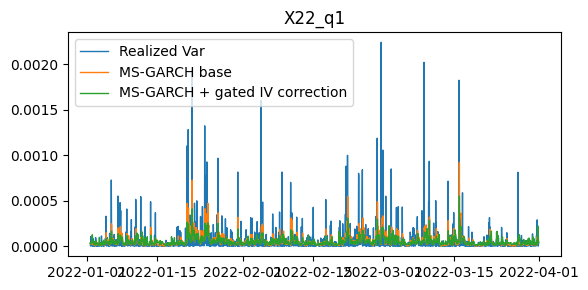

X22_q1
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000156  0.000067 -3.388929 -8.615736 -0.000002
MS_gatedIV  0.000151  0.000062 -3.522130 -8.882136  0.000003


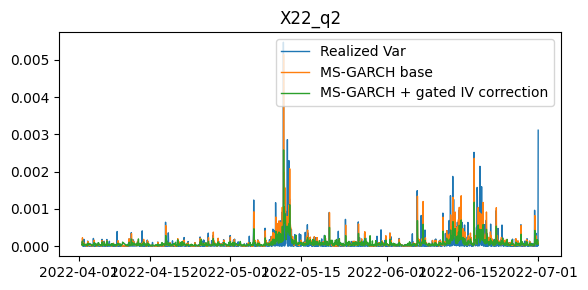

X22_q2
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000254  0.000097 -3.364356 -8.566589 -0.000024
MS_gatedIV  0.000225  0.000083 -3.490568 -8.819013 -0.000003


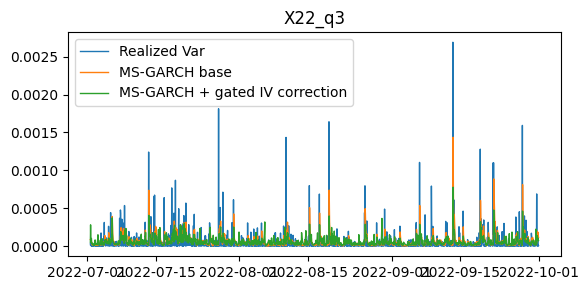

X22_q3
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000154  0.000067 -3.394236 -8.626350 -0.000017
MS_gatedIV  0.000141  0.000064 -3.598167 -9.034212 -0.000014


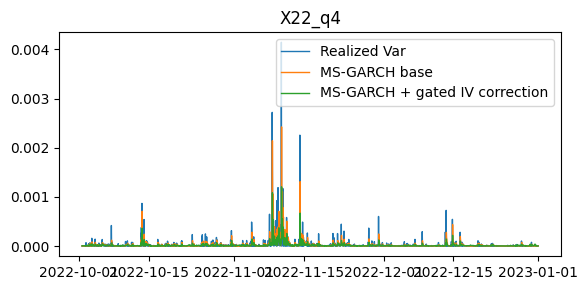

X22_q4
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000154  0.000035 -1.938510 -5.714896 -0.000001
MS_gatedIV  0.000142  0.000029 -3.935007 -9.707892  0.000008


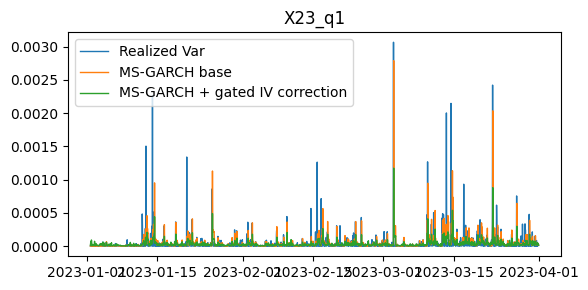

X23_q1
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000176  0.000056 -3.442750 -8.723377 -0.000009
MS_gatedIV  0.000151  0.000044 -3.769623 -9.377123  0.000004


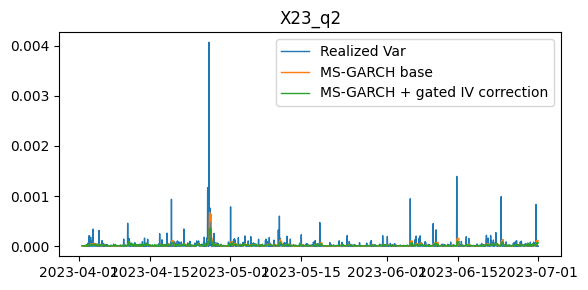

X23_q2
                RMSE       MAE       NLL    QLIKE      Bias
MS_base     0.000117  0.000028 -3.605166 -9.04821  0.000000
MS_gatedIV  0.000113  0.000025 -3.913362 -9.66460  0.000004


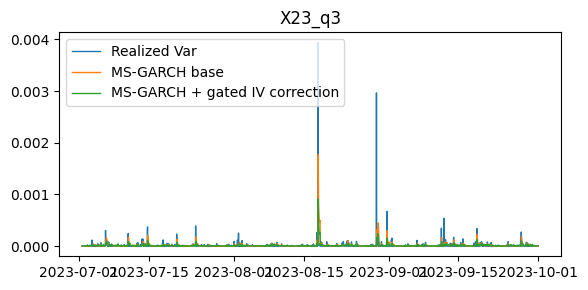

X23_q3
                RMSE       MAE       NLL      QLIKE      Bias
MS_base     0.000121  0.000021 -3.968440  -9.774757 -0.000004
MS_gatedIV  0.000113  0.000017 -4.287971 -10.413819  0.000000


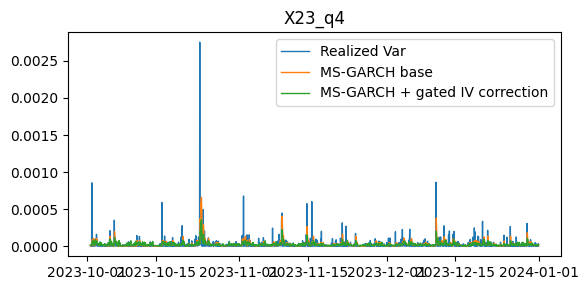

X23_q4
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000085  0.000028 -3.805698 -9.449273 -0.000005
MS_gatedIV  0.000080  0.000025 -4.025321 -9.888519 -0.000002


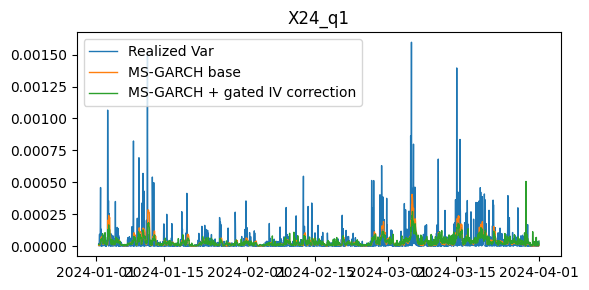

X24_q1
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000100  0.000042 -3.638502 -9.114881  0.000003
MS_gatedIV  0.000099  0.000041 -3.798491 -9.434858  0.000005


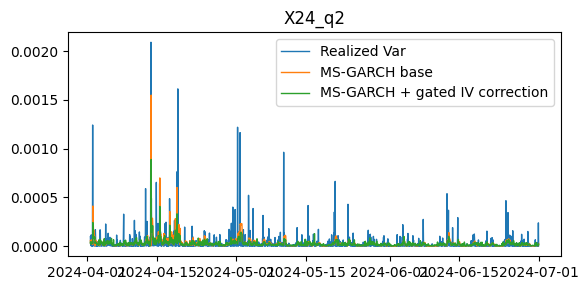

X24_q2
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000099  0.000035 -3.698606 -9.235088  0.000000
MS_gatedIV  0.000094  0.000032 -3.946464 -9.730806  0.000003


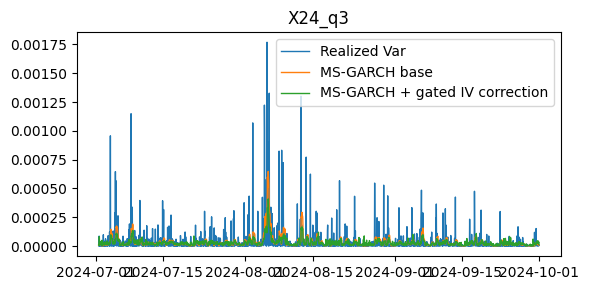

X24_q3
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000111  0.000043 -3.557385 -8.952646  0.000003
MS_gatedIV  0.000109  0.000040 -3.720326 -9.278528  0.000007


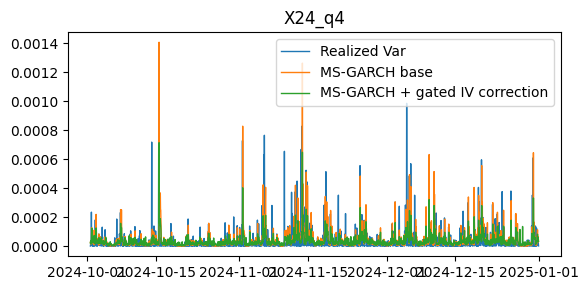

X24_q4
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000104  0.000046 -3.592958 -9.023792 -0.000010
MS_gatedIV  0.000086  0.000039 -3.807973 -9.453824 -0.000002


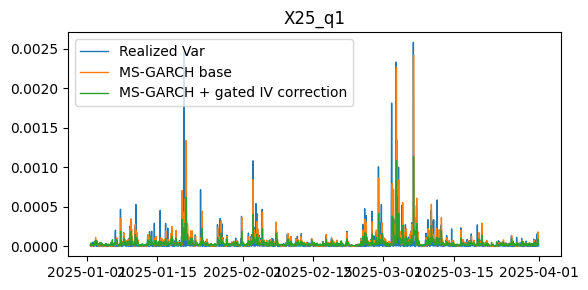

X25_q1
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000160  0.000055 -3.673111 -9.184100 -0.000011
MS_gatedIV  0.000135  0.000043 -3.755520 -9.348916  0.000003


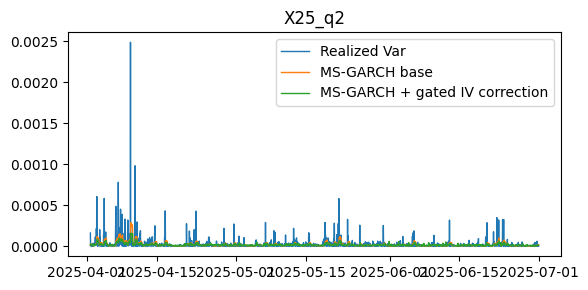

X25_q2
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000077  0.000024 -3.913319 -9.664515  0.000002
MS_gatedIV  0.000076  0.000022 -4.008492 -9.854861  0.000005


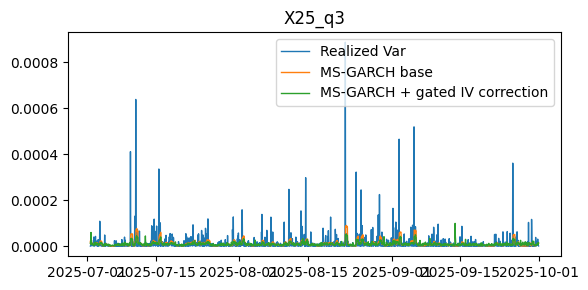

X25_q3
                RMSE       MAE       NLL      QLIKE      Bias
MS_base     0.000038  0.000013 -4.071487  -9.980852  0.000001
MS_gatedIV  0.000038  0.000012 -4.236778 -10.311433  0.000002


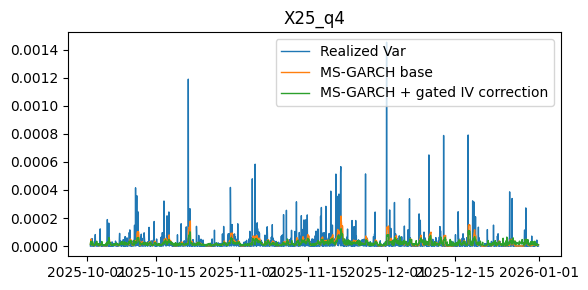

X25_q4
                RMSE       MAE       NLL     QLIKE      Bias
MS_base     0.000074  0.000029 -3.594421 -9.026719  0.000003
MS_gatedIV  0.000072  0.000028 -3.830082 -9.498041  0.000005


In [23]:
# Requires : idx_{q}, f_rollB_{q}  (as globals)

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

quarters = [(f"X{str(y)[-2:]}_{q}", Xq_by_year[y][q]) for y in YEARS for q in ["q1","q2","q3","q4"]]

h_final_byQ = {}
g_hat_byQ   = {}
w_byQ       = {}

tables_gatedIV = {}

for qname, Xq in quarters:

    idx_q    = np.asarray(globals()[f"idx_{qname}"], int)
    f_roll_q = np.asarray(globals()[f"f_rollB_{qname}"], float)

    t_idx  = Xq.index[idx_q]
    df_use = Xq.loc[t_idx, ["rt","bsIV","MFIV"]].copy()

    h_base_s = pd.Series(np.asarray(f_roll_q, float), index=t_idx)

    mask = df_use.notna().all(axis=1) & np.isfinite(h_base_s.values)
    df_use = df_use.loc[mask]
    h_base = h_base_s.loc[mask].to_numpy(float)

    rv = (df_use["rt"].to_numpy(float) ** 2)

    SEQ_LEN = 5
    feats = df_use[["bsIV","MFIV"]].to_numpy(np.float32)
    X_seq = []
    for i in range(SEQ_LEN, len(df_use)):
        X_seq.append(feats[i-SEQ_LEN:i])
    X_seq = torch.tensor(np.stack(X_seq))

    h_base2 = h_base[SEQ_LEN:]
    H = 5
    dt_years = H / (365.25 * 24.0)
    mfiv_H = np.maximum(df_use["MFIV"].to_numpy(float) * dt_years, 1e-12)

    scale = np.nanmedian(h_base2) / np.nanmedian(mfiv_H[SEQ_LEN:])
    h_iv2 = np.maximum(mfiv_H[SEQ_LEN:] * scale, 1e-12)

    rv2 = rv[SEQ_LEN:]
    lstm_corr = LSTMGatedIVCorrection(hidden_dim=32, lr=1e-3, epochs=30).fit_xy(X_seq, rv2, h_base2, h_iv2)

    g_hat = lstm_corr.predict(X_seq, h_base2, h_iv2).ravel()

    h_final = h_base2 * np.exp(g_hat)

    h_final_byQ[qname] = h_final
    g_hat_byQ[qname]   = g_hat
    w_byQ[qname]       = getattr(lstm_corr, "last_w", None)

    x_plot2 = df_use.index[SEQ_LEN:]
    rv2     = rv[SEQ_LEN:]

    globals()[f"rv2_{qname}"]     = rv2
    globals()[f"h_base2_{qname}"] = h_base2
    globals()[f"h_final_{qname}"] = h_final

    plt.figure(figsize=(6,3))
    plt.plot(x_plot2, rv2,     linewidth=1, label="Realized Var")
    plt.plot(x_plot2, h_base2, linewidth=1, label="MS-GARCH base")
    plt.plot(x_plot2, h_final, linewidth=1, label="MS-GARCH + gated IV correction")
    plt.title(qname); plt.legend(); plt.tight_layout(); plt.show()

    results = {}
    results["MS_base"]      = metrics(rv2, h_base2)
    results["MS_gatedIV"]   = metrics(rv2, h_final)

    table = pd.DataFrame(results, index=["RMSE","MAE","NLL","QLIKE","Bias"]).T.round(6)
    tables_gatedIV[qname] = table
    print(qname)
    print(table)


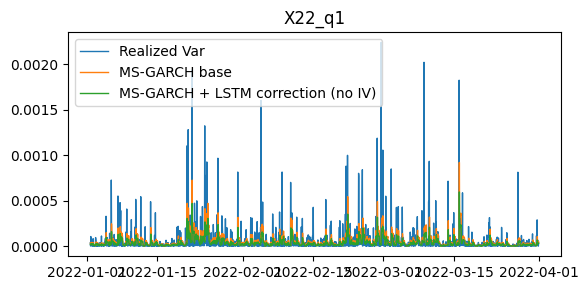

X22_q1
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000156  0.000067 -3.388929 -8.615736 -0.000002
MS_LSTM_noIV  0.000152  0.000056 -3.136663 -8.111203  0.000017


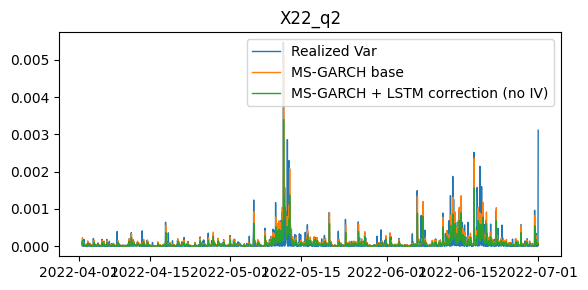

X22_q2
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000254  0.000097 -3.364356 -8.566589 -0.000024
MS_LSTM_noIV  0.000229  0.000077 -3.160849 -8.159575  0.000008


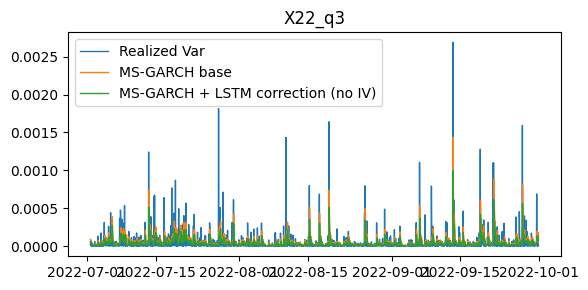

X22_q3
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000154  0.000067 -3.394236 -8.626350 -0.000017
MS_LSTM_noIV  0.000142  0.000055 -3.219838 -8.277553  0.000002


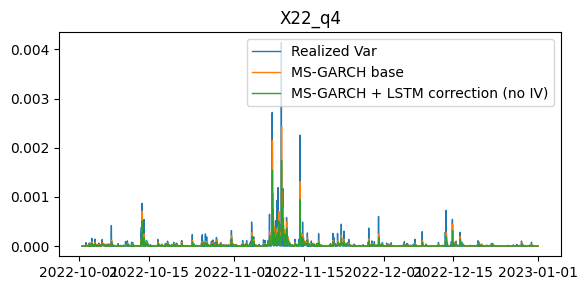

X22_q4
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000154  0.000035 -1.938510 -5.714896 -0.000001
MS_LSTM_noIV  0.000145  0.000031 -0.902288 -3.642453  0.000007


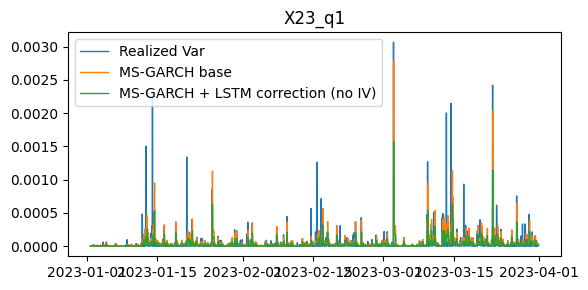

X23_q1
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000176  0.000056 -3.442750 -8.723377 -0.000009
MS_LSTM_noIV  0.000156  0.000042 -2.812583 -7.463043  0.000010


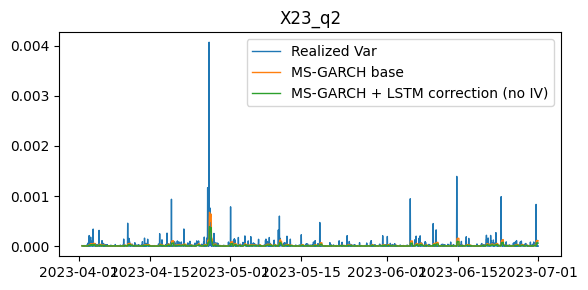

X23_q2
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000117  0.000028 -3.605166 -9.048210  0.000000
MS_LSTM_noIV  0.000113  0.000023 -2.982038 -7.801954  0.000009


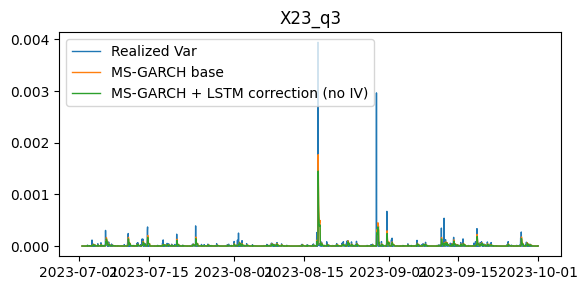

X23_q3
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000121  0.000021 -3.968440 -9.774757 -0.000004
MS_LSTM_noIV  0.000117  0.000019 -3.800383 -9.438643 -0.000001


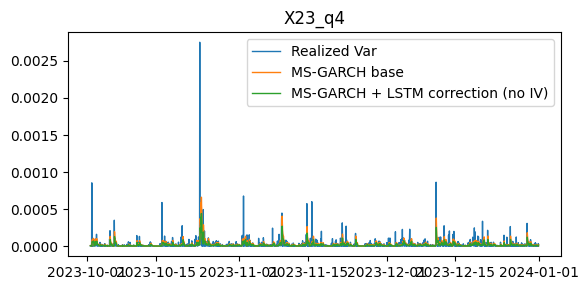

X23_q4
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000085  0.000028 -3.805698 -9.449273 -0.000005
MS_LSTM_noIV  0.000081  0.000023 -3.540999 -8.919875  0.000003


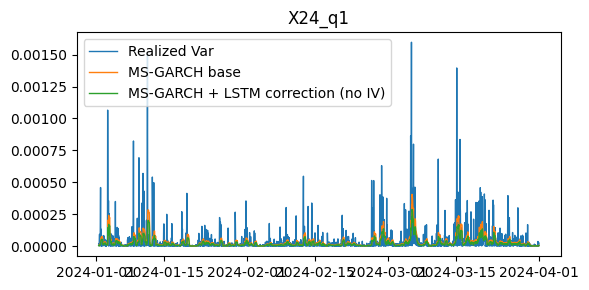

X24_q1
                RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.0001  0.000042 -3.638502 -9.114881  0.000003
MS_LSTM_noIV  0.0001  0.000037 -3.429403 -8.696683  0.000013


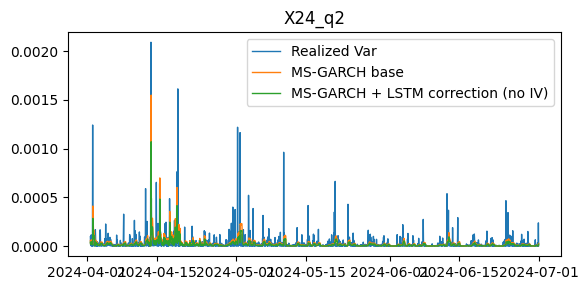

X24_q2
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000099  0.000035 -3.698606 -9.235088  0.000000
MS_LSTM_noIV  0.000096  0.000030 -3.424816 -8.687509  0.000009


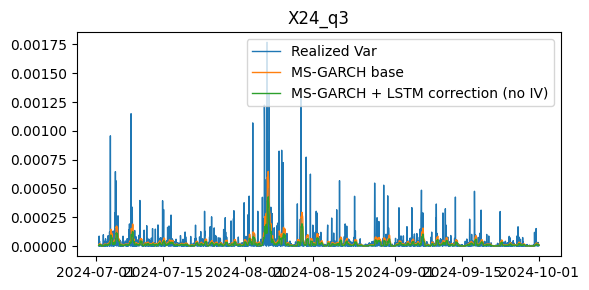

X24_q3
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000111  0.000043 -3.557385 -8.952646  0.000003
MS_LSTM_noIV  0.000110  0.000038 -3.252600 -8.343077  0.000014


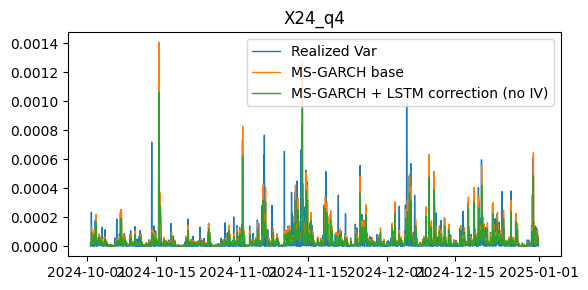

X24_q4
                  RMSE       MAE       NLL     QLIKE     Bias
MS_base       0.000104  0.000046 -3.592958 -9.023792 -0.00001
MS_LSTM_noIV  0.000093  0.000039 -3.432957 -8.703792  0.00000


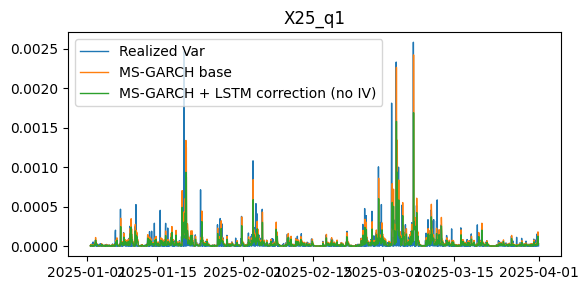

X25_q1
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000160  0.000055 -3.673111 -9.184100 -0.000011
MS_LSTM_noIV  0.000143  0.000045 -3.479638 -8.797153  0.000004


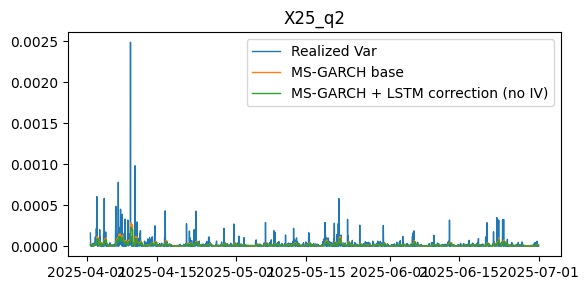

X25_q2
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000077  0.000024 -3.913319 -9.664515  0.000002
MS_LSTM_noIV  0.000076  0.000022 -3.788098 -9.414073  0.000006


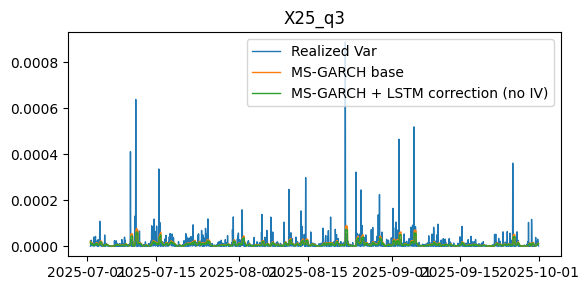

X25_q3
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000038  0.000013 -4.071487 -9.980852  0.000001
MS_LSTM_noIV  0.000038  0.000012 -3.941128 -9.720133  0.000003


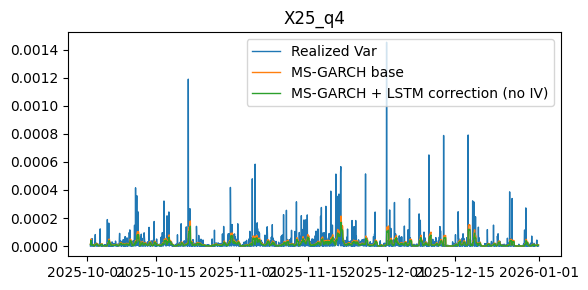

X25_q4
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000074  0.000029 -3.594421 -9.026719  0.000003
MS_LSTM_noIV  0.000073  0.000027 -3.408858 -8.655593  0.000007


In [24]:
# MS-GARCH base + LSTM correction (NO IV) per quarter
import torch

quarters = [(f"X{str(y)[-2:]}_{q}", Xq_by_year[y][q]) for y in YEARS for q in ["q1","q2","q3","q4"]]

tables_noIV = {}

for qname, Xq in quarters:

    idx_q    = np.asarray(globals()[f"idx_{qname}"], int)
    f_roll_q = np.asarray(globals()[f"f_rollB_{qname}"], float)

    t_idx  = Xq.index[idx_q]
    df_use = Xq.loc[t_idx, ["rt"]].copy()

    h_base_s = pd.Series(f_roll_q, index=t_idx)

    mask = df_use["rt"].notna() & np.isfinite(h_base_s.values)
    df_use = df_use.loc[mask]
    h_base = h_base_s.loc[mask].to_numpy(float)

    rv = (df_use["rt"].to_numpy(float) ** 2)
    g  = np.log(rv + 1e-12) - np.log(h_base + 1e-12)

    SEQ_LEN = 5
    feats = df_use[["rt"]].to_numpy(np.float32)

    X_seq, y = [], []
    for i in range(SEQ_LEN, len(df_use)):
        X_seq.append(feats[i-SEQ_LEN:i])
        y.append(g[i])

    X_seq = torch.tensor(np.stack(X_seq))
    y     = torch.tensor(np.array(y, np.float32)).view(-1, 1)

    from src.LSTM_lib import LSTMcorrNoIV
    lstm_corr = LSTMcorrNoIV(hidden_dim=32, lr=1e-3, epochs=30).fit_xy(X_seq, y)
    g_hat = lstm_corr.predict(X_seq)

    h_base2  = h_base[SEQ_LEN:]
    h_finalB = h_base2 * np.exp(g_hat)

    x_plot2 = df_use.index[SEQ_LEN:]
    rv2     = rv[SEQ_LEN:]

    plt.figure(figsize=(6,3))
    plt.plot(x_plot2, rv2,      linewidth=1, label="Realized Var")
    plt.plot(x_plot2, h_base2,  linewidth=1, label="MS-GARCH base")
    plt.plot(x_plot2, h_finalB, linewidth=1, label="MS-GARCH + LSTM correction (no IV)")
    plt.title(qname); plt.legend(); plt.tight_layout(); plt.show()

    results = {}
    results["MS_base"]      = metrics(rv2, h_base2)
    results["MS_LSTM_noIV"] = metrics(rv2, h_finalB)

    table = pd.DataFrame(results, index=["RMSE","MAE","NLL","QLIKE","Bias"]).T.round(6)
    tables_noIV[qname] = table
    print(qname)
    print(table)

    globals()[f"rv2_{qname}"]      = rv2
    globals()[f"h_base2_{qname}"]  = h_base2
    globals()[f"h_finalB_{qname}"] = h_finalB


## Evaluation

In [25]:
quarters = [(f"X{str(y)[-2:]}_{q}", Xq_by_year[y][q]) for y in YEARS for q in ["q1","q2","q3","q4"]]

tables_all = {}

for qname, _ in quarters:
    results = {}

    rv2_q      = globals()[f"rv2_{qname}"]
    h_base2_q  = globals()[f"h_base2_{qname}"]
    h_finalB_q = globals()[f"h_finalB_{qname}"]
    h_final_q  = globals()[f"h_final_{qname}"]

    results["MS_base"]      = metrics(rv2_q, h_base2_q)
    results["MS_LSTM_noIV"] = metrics(rv2_q, h_finalB_q)
    results["MS_LSTM_wIV"]  = metrics(rv2_q, h_final_q)

    table = pd.DataFrame(results, index=["RMSE","MAE","NLL","QLIKE","Bias"]).T.round(6)
    tables_all[qname] = table

    print(qname)
    print(table)


X22_q1
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000156  0.000067 -3.388929 -8.615736 -0.000002
MS_LSTM_noIV  0.000152  0.000056 -3.136663 -8.111203  0.000017
MS_LSTM_wIV   0.000151  0.000062 -3.522130 -8.882136  0.000003
X22_q2
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000254  0.000097 -3.364356 -8.566589 -0.000024
MS_LSTM_noIV  0.000229  0.000077 -3.160849 -8.159575  0.000008
MS_LSTM_wIV   0.000225  0.000083 -3.490568 -8.819013 -0.000003
X22_q3
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000154  0.000067 -3.394236 -8.626350 -0.000017
MS_LSTM_noIV  0.000142  0.000055 -3.219838 -8.277553  0.000002
MS_LSTM_wIV   0.000141  0.000064 -3.598167 -9.034212 -0.000014
X22_q4
                  RMSE       MAE       NLL     QLIKE      Bias
MS_base       0.000154  0.000035 -1.938510 -5.714896 -0.000001
MS_LSTM_noIV  0.000145  0.000031 -0.902288 -3.642453  0.000007
MS_LSTM_wIV   0.000142  0.0

### LSTM correction procedure (what we do)

For each time $t$, define realized variance and the MS-GARCH base variance:
$$RV_t = r_t^2,$$
$$h^{\text{base}}_t = \text{MS-GARCH forecast variance at }t.$$

Define the log-correction target:
$$g_t = \log(RV_t+\varepsilon) - \log(h^{\text{base}}_t+\varepsilon).$$

Build an input sequence of length $L$ (our `SEQ_LEN`) from features $x_t$:
$$S_t = [x_{t-L}, x_{t-L+1}, \dots, x_{t-1}].$$

LSTM mapping:
$$h_t^{\text{LSTM}} = \mathrm{LSTM}(S_t), \qquad \hat g_t = W h_t^{\text{LSTM}} + b.$$

Final variance forecast:
$$\hat h_t = h^{\text{base}}_t \exp(\hat g_t).$$

**Variables:**  
$r_t$ = hourly return; $RV_t$ = realized variance; $h^{\text{base}}_t$ = MS-GARCH base variance;  
$x_t$ = input features (either $[bsIV_t, MFIV_t]$ or $[r_t]$); $L$ = sequence length;  
$\hat g_t$ = predicted log-correction; $\hat h_t$ = corrected variance forecast; $\varepsilon=10^{-12}$.
